In [207]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import rsa

## Encoding and Decoding Functions

In [208]:
def audio_from_wav(filename, save_mono=False):
    fs, data = wavfile.read(filename)
    audio = (data[:,0] + data[:,1]) // 2
    if (save_mono):
        data[:,0] = audio
        data[:,1] = audio
        filename = filename.split('.')[0] + '_mono.wav'
        wavfile.write(filename, fs, data)
    return fs, audio

def audio_to_wav(audio, filename, fs, N_original):
    data = np.zeros((N_original, 2)).astype(np.int16)
    data[:,0] = audio[0:N_original]
    data[:,1] = audio[0:N_original]
    wavfile.write(filename, fs, data)

def pad_audio(audio, fs, df):
    N = len(audio)
    N_min = fs/df
    N_req = int((N // N_min + 1) * N_min - N)
    pad = np.linspace(0, 0, N_req)
    audio = np.concatenate((audio, pad))
    return audio

def remove_low_frequencies(audio, fs, f_max):
    audio_fft = np.fft.rfft(audio)
    audio_fft[0:len(audio)*f_max//fs] = 0
    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def add_data(audio, data, ampl, fs, df, f_min):
    f_min = max(f_min, df)
    
    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            audio_fft[f] = ampl * data[f_d]
            f_d += 1
            if f_d == len(f_data):
                break

    audio = np.real(np.fft.irfft(audio_fft))
    return audio

def recover_data(audio, data_ampl, data_len, fs, df, f_min):
    data = np.zeros(data_len)

    f_data = np.linspace(f_min, f_min + (len(data)-1) * df, len(data))
    f_audio = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    f_d = 0
    for f in range(len(f_audio)):
        if (f_data[f_d] <= f_audio[f]):
            if (audio_fft[f] > data_ampl/2):
                data[f_d] = 1
            f_d += 1
            if f_d == len(f_data):
                break
    return data

## Encryption Functions

[-194. -278. -320. -264. -302. -388. -328. -426. -462. -280. -326. -350.
 -434. -328. -304. -430. -404. -266. -442. -278. -280. -328.  -36.  -10.
  -56. -300.  -64. -360.    4. -160.  -32. -368. -352. -312.  -46.   20.
 -154.   22.  -42. -244.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
<class 'numpy.int64'>
1000000000000000000000111010111000111111
['10000000', '00000000', '00000011', '10101110', '00111111']


ValueError: chr() arg not in range(0x110000)

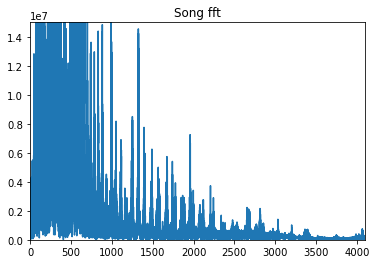

In [209]:
def create_keys(length):
    public_key, private_key = rsa.newkeys(length)

    with open('public_key.pem', 'wb') as f:
        f.write(public_key.save_pkcs1())
    
    with open('private_key.pem', 'wb') as f:
        f.write(private_key.save_pkcs1())
        
    return public_key, private_key

def encrypt_data(message, private_key):
    return rsa.sign(message.encode(), private_key, 'SHA-1')

def check_data(message, sign_message , public_key):
    try:
        rsa.verify(message.encode(), sign_message, public_key)
        return True
    except:
        return False
    

def extract_audio_signature(audio_name):
    fs, audio = audio_from_wav(audio_name)

    # total = 0
    # numtotal = 0

    # Sec_compare_count = np.zeros(160)
    # output = np.zeros(160)

    # start inputs
    f_start = 100
    f_end = 4100
    df = 1
    section_size = 100

    averages = np.zeros((f_end-f_start)//section_size)
    counts = np.zeros(len(averages))
    output = np.zeros(len(averages))

    # fouriatransform audio
    audio = pad_audio(audio, fs, df)
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)

    # calculate average for all
    section = 0
    total = 0
    section_start = f_start + section * section_size
    section_end = section_start + section_size
    count = 0
    for i in range(len(f_full)):
        if (f_full[i] > section_start and f_full[i] <= section_end):
            total += np.abs(audio_fft[i])
            count+=1
        if (f_full[i] >= section_end):
            averages[section] = total / count
            count = 0
            section += 1
            section_start = f_start + section * section_size
            section_end = section_start + section_size
            total = 0
            if (section == len(averages)):
                break

    # for i in range(len(f_full)):
    #     f_full_round = np.around(f_full[i], 2)
    #     if (f_full_round%df == 0):
    #         if f_full[i] >= f_start and f_full[i] <= f_end:
    #             total += np.abs(audio_fft[i])
    #             numtotal += 1
    
    section = 0
    section_start = f_start + section * section_size
    section_end = section_start + section_size
    for i in range(len(f_full)):
        if (f_full[i] > section_start and f_full[i] <= section_end):
            if (np.abs(audio_fft[i]) >= averages[section]):
                counts[section] += 1
            else:
                counts[section] -= 1
        if (f_full[i] >= section_end):
            section += 1
            section_start = f_start + section * section_size
            section_end = section_start + section_size
            if (section == len(averages)):
                break


    counts_average = np.average(counts)
    for i in range(len(counts)):
        output[i] = (counts[i] > counts_average)

    # # calculate num above or below for each section
    # for i in range(len(f_full)):
    #     f_full_round = np.around(f_full[i], 2)
    #     if (f_full_round%df == 0):
    #         for j in range(160):
    #             temp_start = f_start + j * 100
    #             temp_end = temp_start + 100
    #             if f_full[i] >= temp_start and f_full[i] <= temp_end:
    #                 if np.abs(audio_fft[i]) >= ave:
    #                     Sec_compare_count[j] += 1
    #                 else:
    #                     Sec_compare_count[j] -= 1
                        
         
    # for i in range(160):
    #     if Sec_compare_count[i] > 0:
    #         output[i] = 1
    #     else:
    #         output[i] = 0

    plot_fft(audio, fs, f_end)
    print(counts)
    print(output)
    return output.astype(int)


def convert_bit_array_to_string(bit_array):
    print(type(bit_array[0]))
    binary_string = ''.join(str(bit) for bit in bit_array)
    print(binary_string)
    ascii_chars = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]
    print(ascii_chars)
    string = ''.join(chr(int(char)) for char in ascii_chars)
    return string

def bytes_to_binary(bytes_obj):
    return ''.join(format(byte, '08b') for byte in bytes_obj)

def binary_to_bytes(binary_str):
    return bytes(int(binary_str[i:i+8], 2) for i in range(0, len(binary_str), 8))


def get_data(audio_name,private_key):
    message = convert_bit_array_to_string(extract_audio_signature(audio_name))
    sign_message = encrypt_data(message, private_key)
    bin_sign_message=bytes_to_binary(sign_message)    
    bin_data = [int(bit) for bit in bin_sign_message]
    return bin_data


def check_data(audio_name, bin_data_arry , public_key):
    message = convert_bit_array_to_string(extract_audio_signature(audio_name))
    bin_data = ''.join(str(bit) for bit in bin_data_arry)
    sign_message = binary_to_bytes(bin_data)
    return check_data(message, sign_message, public_key)
    

print(convert_bit_array_to_string(extract_audio_signature('AudioFiles/bumblebee/bumblebee_small.wav')))



## Helper Functions

In [ ]:
def plot_fft(audio, fs, f_max = 250):
    f_full = np.fft.rfftfreq(len(audio), 1/fs)
    audio_fft = np.fft.rfft(audio)
    plt.figure()
    plt.plot(f_full, np.abs(audio_fft))
    plt.xlim([0, f_max])
    plt.ylim([0, 1.5e7])
    plt.title('Song fft')

## Implentation

In [ ]:
DELTA_FREQUENCIES = 0.2 # Hz
LOWEST_FREQUENCY = 1 # Hz
DATA_LENGTH = 368
BINARY_AMPLITUDES = 0.5e7

def encrypt_audio(filename):
    # Keys and data
    public_key, private_key = create_keys(365);
    data = get_data(filename, private_key)

    # Audio from file
    fs, audio = audio_from_wav(filename, True)
    N_original = len(audio)
    # plot_fft(audio, fs)

    # Add data to audio
    audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
    audio = remove_low_frequencies(audio, fs, 100)
    # plot_fft(audio, fs)
    audio = add_data(audio, data, BINARY_AMPLITUDES, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY)
    # plot_fft(audio, fs)
    plot_fft(audio, fs)

    # Save audio to file
    audio_to_wav(audio, filename.split('.')[0] + '_with_data.wav', fs, N_original)
    return public_key, private_key

    

def check_audio(filename, public_key):
    fs, audio = audio_from_wav(filename)
    audio = pad_audio(audio, fs, DELTA_FREQUENCIES)
    plot_fft(audio, fs)

    data_r = recover_data(audio, BINARY_AMPLITUDES, DATA_LENGTH, fs, DELTA_FREQUENCIES, LOWEST_FREQUENCY).astype(int)
    check = check_data(filename,data_r,public_key)
    return check

-194
-278
-320
-264
-302
-388
-328
-426
-462
-280
-326
-350
-434
-328
-304
-430
-404
-266
-442
-278
-280
-328
-36
-10
-56
-300
-64
-360
4
-160
-32
-368
-352
-312
-46
20
-154
22
-42
-244
[ 7111488.48517879 13603924.77802676  8001340.06678819  5541814.68227775
  9676716.09212248  5628703.32473178  2542419.13049291  2111765.41199825
  1722216.32839432  1154954.7336019   1081812.81520539   988845.02912755
  1456013.88730916   868855.20653363   749470.91257069   701296.31132224
   596287.22192213   669135.84478934   806385.8339666    535939.18221298
   562879.91612325   573985.39181129   416133.37137032   389070.53935408
   390340.74065641   581986.96889436   370287.69793276   470251.59529092
   296751.37282874   275181.42908678   212710.04752405   201084.19920084
   226819.49928774   125077.51296161    91449.90177573    72827.12410135
    96693.75011215    95736.43657299   119039.54960589   189764.54195878]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 

ValueError: embedded null byte

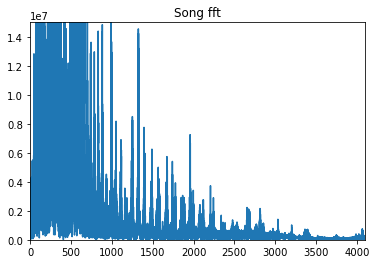

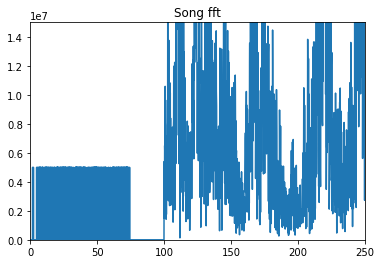

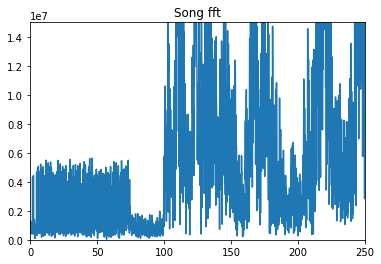

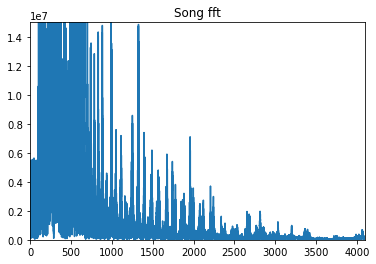

In [ ]:
public_key, _ = encrypt_audio('AudioFiles/bumblebee/bumblebee_small.wav')
print(check_audio('AudioFiles/bumblebee/bumblebee_small_with_data.wav', public_key))
